In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import datetime
import matplotlib
from matplotlib import pyplot

In [2]:
prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/V1.1FeaturesWithLabels20131201To20180430.csv', parse_dates=['Date'], low_memory=False)
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "UnifiedRegion", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    
if(normalize):
    #normalize data; not necessary for xgboost
    scaler = Normalizer()
    dontNormalize = input_categorical_columns + output_columns + prediction_trend_data + metadata_columns
    df.loc[:, ~df.columns.isin(dontNormalize)] = scaler.fit_transform(df.loc[:, ~df.columns.isin(dontNormalize)])

In [3]:
df = df[df['o_Day1DangerAboveTreeline']!='no-data']
df = df[df['o_Day1DangerNearTreeline']!='no-data']
df = df[df['o_Day1DangerBelowTreeline']!='no-data']

In [11]:
splitBySeason = True
yColumns = ['o_Day1DangerAboveTreeline']
yNearColumn = ['o_Day1DangerNearTreeline']
yBelowColumn = ['o_Day1DangerBelowTreeline']

if(splitBySeason):
    df_train = df[df['Date'] < datetime.datetime(2017, 5, 1) ] 
    df_test = df[df['Date'] > datetime.datetime(2017, 5, 1)]
    
    #same x input trained to get a different output
    X_Above_train = X_Near_train = X_Below_train = df_train[input_numeric_columns+input_categorical_columns]
    y_Above_train = df_train[yColumns + metadata_columns]
    y_Near_train = df_train[yNearColumn + metadata_columns]
    y_Below_train = df_train[yBelowColumn + metadata_columns]
    
    X_Above_test = X_Near_test = X_Below_test = df_test[input_numeric_columns+input_categorical_columns]
    y_Above_test = df_test[yColumns + metadata_columns]
    y_Near_test = df_test[yNearColumn + metadata_columns]
    y_Below_test = df_test[yBelowColumn + metadata_columns]
else:
    #random stratified split
    X = df[input_numeric_columns+input_categorical_columns]
    
    yAbove=df[yColumns + metadata_columns]
    X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_Day1DangerAboveTreeline"], test_size=0.20, random_state=1)
    
    yNear=df[yNearColumn+metadata_columns]
    X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_Day1DangerNearTreeline'], test_size=0.20, random_state=1)
    
    yBelow=df[yBelowColumn+metadata_columns]
    X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_Day1DangerBelowTreeline'], test_size=0.20, random_state=1)

In [16]:
X_Below_train.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev3DayWindSlabLikeliness8InPast,c_r_Prev7DayWindSlabLikeliness8InPast,c_r_Prev3DayFreezeThawLikeliness9InPast,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast
0,0.0,0.467704,0.0,1.263505,0.0,1.475613,0.0,1.499958,0.000,1.601572,...,1,1,1,1,1,1,1,1,0,0
1,0.0,0.442660,0.0,1.015936,0.0,1.259327,0.0,1.249707,0.000,1.153861,...,1,1,1,1,1,1,1,1,0,0
2,0.0,0.821498,0.0,1.296315,0.0,1.545797,0.0,1.576965,0.000,1.661694,...,1,1,1,1,1,1,1,1,0,0
3,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,1,1,1,1,1,1,1,1,0,0
4,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,1,1,1,1,1,1,1,1,0,0


In [17]:
y_Below_test['o_Day1DangerBelowTreeline'].value_counts()

Moderate        15952
Low             12377
Considerable     6950
High             1039
Name: o_Day1DangerBelowTreeline, dtype: int64

In [18]:
#parameters derived from a several step parameter search
grid = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7}

modelAbove = XGBClassifier(n_jobs=10)
modelAbove.set_params(**grid)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [23]:
modelNear = XGBClassifier(n_jobs=10)
modelNear.set_params(**grid)

modelBelow = XGBClassifier(n_jobs=10)
modelBelow.set_params(**grid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [19]:
val = modelAbove.fit(X_Above_train, y_Above_train[yColumns].values.ravel())


In [24]:
valnear = modelNear.fit(X_Near_train, y_Near_train[yNearColumn].values.ravel())
valbelow = modelBelow.fit(X_Below_train, y_Below_train[yBelowColumn].values.ravel())

In [25]:
resultAbove = modelAbove.predict(X_Above_test)
resultNear = modelNear.predict(X_Near_test)
resultBelow = modelBelow.predict(X_Below_test)

C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.6018503221543037
Classification Report
              precision    recall  f1-score   support

Considerable       0.56      0.65      0.60     13055
        High       0.45      0.27      0.34      2598
         Low       0.28      0.01      0.03      3330
    Moderate       0.65      0.73      0.69     17335

 avg / total       0.57      0.60      0.57     36318

Normalized confusion matrix
Confusion matrix, without normalization


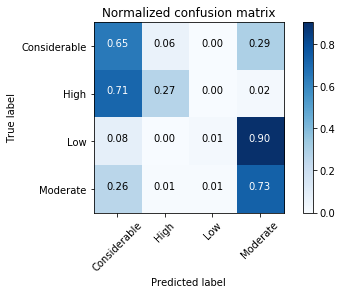

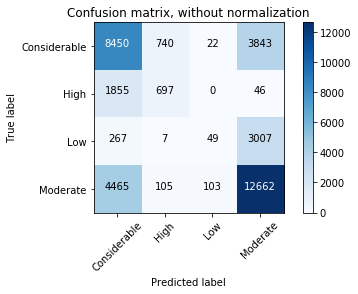

In [26]:
evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], resultAbove)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], resultAbove)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

Accuracy: 0.5403931934577896
Classification Report
              precision    recall  f1-score   support

Considerable       0.50      0.55      0.53     10460
        High       0.32      0.13      0.18      1710
         Low       0.34      0.03      0.06      6659
    Moderate       0.57      0.77      0.65     17489

 avg / total       0.50      0.54      0.49     36318

Normalized confusion matrix
Confusion matrix, without normalization


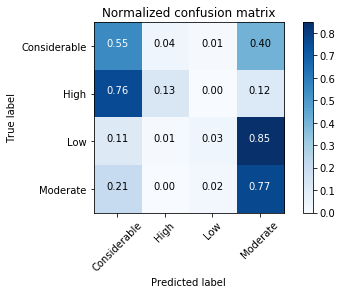

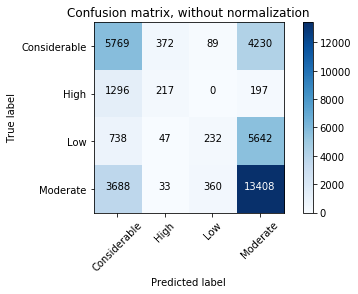

In [27]:
evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], resultNear)

cnf_matrix = confusion_matrix(y_Near_test['o_Day1DangerNearTreeline'], resultNear)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

Accuracy: 0.4875268461919709
Classification Report
              precision    recall  f1-score   support

Considerable       0.38      0.18      0.25      6950
        High       0.18      0.02      0.03      1039
         Low       0.60      0.34      0.44     12377
    Moderate       0.47      0.76      0.58     15952

 avg / total       0.49      0.49      0.45     36318

Normalized confusion matrix
Confusion matrix, without normalization


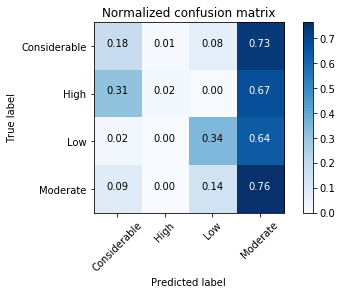

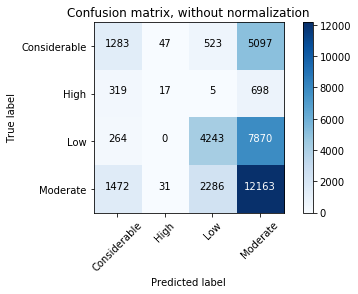

In [28]:
evaluateSingleClassShort(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
cnf_matrix = confusion_matrix(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [29]:
#check out the feature importances
featureImportance = dict(zip(X_Above_train.columns, modelAbove.feature_importances_))
sortedFeatureImportance = sorted(featureImportance, key=featureImportance.get, reverse=True)

In [30]:
sortedFeatureImportance[:100]

['n_r_Prev1DayPrecip',
 'n_r_Prev1DayPrecip1InPast',
 'n_r_Prev1DayPrecip8InPast',
 'n_r_Prev1DayPrecip9InPast',
 'n_r_Prev1DayPrecip4InPast',
 'n_r_Prev1DayPrecip10InPast',
 'n_r_Prev1DayPrecip3InPast',
 'n_r_Prev1DayPrecip2InPast',
 'n_r_Prev1DayPrecip6InPast',
 'n_r_Prev1DayMax10mWind',
 'n_r_Prev1DayPrecip5InPast',
 'n_f_APCPsurface',
 'n_f_Next24HourChangeInTempFromPrev3DayMax',
 'n_r_Prev1DayMax10mWind8InPast',
 'n_f_10mWindSpeedMax',
 'n_r_Prev1DayMax10mWind6InPast',
 'n_f_tempMaxF',
 'n_r_Prev1DayMax10mWind1InPast',
 'n_r_Prev1DayPrecip7InPast',
 'n_r_Prev1DayMax10mWind2InPast',
 'n_r_Prev1DayMax10mWind5InPast',
 'n_r_Prev7DayMax10mWind10InPast',
 'n_r_Prev7daySnowAccumulation10InPast',
 'n_r_Prev1DayMax10mWind9InPast',
 'n_r_SNOWDAS_LiquidPrecip_kgpersquarem2InPast',
 'n_r_Prev1DayMax10mWind7InPast',
 'n_r_Prev1DayMax10mWind4InPast',
 'n_f_Next24HoursChangeInTempFromPrev1DayMax',
 'n_r_Prev1DayMax10mWind10InPast',
 'n_r_SNOWDAS_SolidPrecip_kgpersquarem',
 'n_f_tempMinF',
 'n_r

In [ ]:
#save the models
modelAbove._Booster.save_model("ModelAboveV1.bin")
modelNear._Booster.save_model("ModelNearV1.bin")
modelBelow._Booster.save_model("ModelBelowV1.bin")